## Create an Asynchronous endpoint

### SageMaker setup

In [76]:
import boto3

# Specify your AWS Region
aws_region='ap-south-1'

role = get_execution_role()

# Create a low-level SageMaker service client.
sagemaker_client = boto3.client('sagemaker', region_name=aws_region)

# Role to give SageMaker permission to access AWS services.
sagemaker_role= get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Locate the model

In [77]:
import boto3

In [78]:
#Create a variable w/ the model S3 URI
s3_bucket = 'rns-conclave-2023' # Provide the name of your S3 bucket
bucket_prefix=''
model_s3_key = f"model.tar.gz"

#Specify S3 bucket w/ model
model_url = f"s3://{s3_bucket}/{model_s3_key}"

### Identify the container

In [79]:
from sagemaker import image_uris

# Specify an AWS container image. 
container = "684473352813.dkr.ecr.ap-south-1.amazonaws.com/new-pytorch-inference-container-extension-aging-gpu-v2:latest"

### Create a model

In [80]:
model_name = 'conclave-time-traveler-model-4'

#Create model
create_model_response = sagemaker_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = sagemaker_role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_url,
        'Environment':{
            'TS_MAX_REQUEST_SIZE': '100000000',
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        },
    })

### Create endpoint configuration

In [81]:
import datetime
from time import gmtime, strftime

# Create an endpoint config name. Here we create one based on the date  
# so it we can search endpoints based on creation time.
endpoint_config_name = f"ConclaveTimeTravelerEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"

# The name of the model that you want to host. This is the name that you specified when creating the model.
#model_name='<The_name_of_your_model>'
# This has been already set in the earlier cell

create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name, # You will specify this name in a CreateEndpoint request.
    # List of ProductionVariant objects, one for each model that you want to host at this endpoint.
    ProductionVariants=[
        {
            "VariantName": "variant1", # The name of the production variant.
            "ModelName": model_name, 
            "InstanceType": "ml.g4dn.xlarge", # Specify the compute instance type.
            "InitialInstanceCount": 1 # Number of instances to launch initially.
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            # Location to upload response outputs when no location is provided in the request.
            "S3OutputPath": f"s3://{s3_bucket}/output",
            # (Optional) specify Amazon SNS topics
            "NotificationConfig": {
                "SuccessTopic": "arn:aws:sns:ap-south-1:684473352813:Model_Success",
                "ErrorTopic": "arn:aws:sns:ap-south-1:684473352813:Model_Failure",
            }
        },
        "ClientConfig": {
            # (Optional) Specify the max number of inflight invocations per instance
            # If no value is provided, Amazon SageMaker will choose an optimal value for you
            "MaxConcurrentInvocationsPerInstance": 4
        }
    }
)

print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:ap-south-1:684473352813:endpoint-config/conclavetimetravelerendpointconfig-2023-11-04-13-48-03


### Create endpoint

In [107]:
# The name of the endpoint.The name must be unique within an AWS Region in your AWS account.
endpoint_name = "time-traveler-endpoint-8"

# The name of the endpoint configuration associated with this endpoint.
#endpoint_config_name='<endpoint-config-name>'
# This has already been set up in the previous cell

create_endpoint_response = sagemaker_client.create_endpoint(
                                            EndpointName=endpoint_name, 
                                            EndpointConfigName=endpoint_config_name) 


## Invoke the asynchronous endpoint

In [108]:
# Create a low-level client representing Amazon SageMaker Runtime
sagemaker_runtime = boto3.client("sagemaker-runtime", region_name="ap-south-1")

# Specify the location of the input. Here, a single JPEG file
input_location = "s3://rns-conclave-2023/input/Test-Picture-Of-Self.jpg"

# After you deploy a model into production using SageMaker hosting 
# services, your client applications use this API to get inferences 
# from the model hosted at the specified endpoint.
response = sagemaker_runtime.invoke_endpoint_async(
                            EndpointName=endpoint_name, 
                            ContentType='image/jpeg',
                            Accept='application/x-npy',
                            InputLocation=input_location,
                            InvocationTimeoutSeconds=900)

In [109]:
import json
from pprint import pprint

pprint(response)

{'InferenceId': 'afdbf110-ea8b-4286-a295-6fa6c7546e3a',
 'OutputLocation': 's3://rns-conclave-2023/output/909d1d3e-a0ec-474a-92df-752909be1df7.out',
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '54',
                                      'content-type': 'application/json',
                                      'date': 'Sun, 05 Nov 2023 07:03:16 GMT',
                                      'x-amzn-requestid': '3bcf0fff-9021-45b4-a88f-5b7f59192c42',
                                      'x-amzn-sagemaker-outputlocation': 's3://rns-conclave-2023/output/909d1d3e-a0ec-474a-92df-752909be1df7.out'},
                      'HTTPStatusCode': 202,
                      'RequestId': '3bcf0fff-9021-45b4-a88f-5b7f59192c42',
                      'RetryAttempts': 0}}


### Check the results

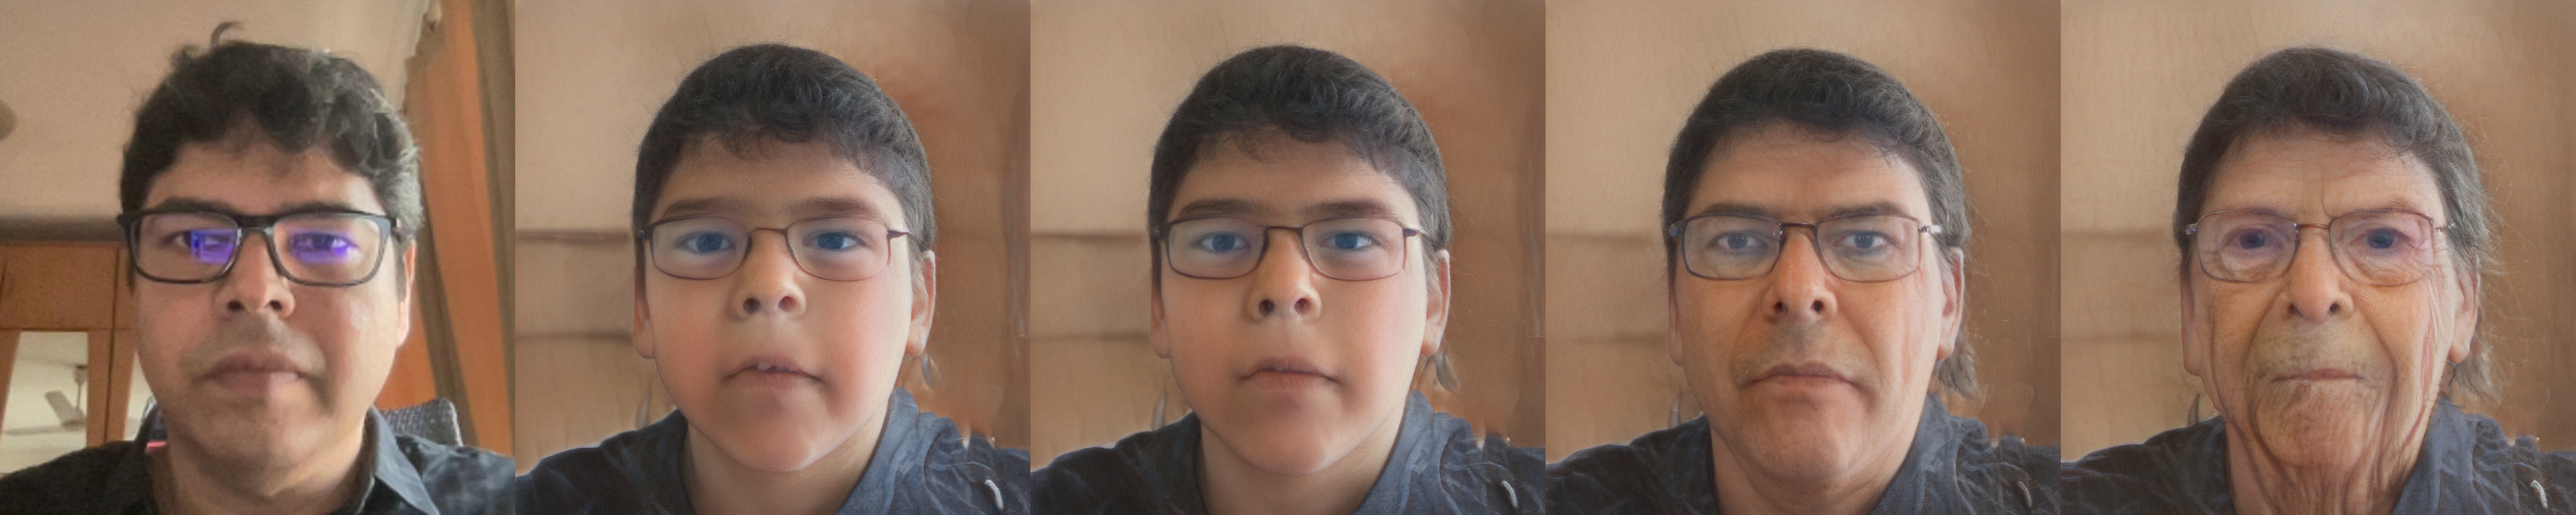

In [110]:
from PIL import Image
import numpy as np

results = np.load(f"./909d1d3e-a0ec-474a-92df-752909be1df7.out")
imgs = Image.fromarray(results)
imgs

### If you want to update the endpoint

In [25]:
endpoint_config_name = "MyConfig-Update"

create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name, # You will specify this name in a CreateEndpoint request.
    # List of ProductionVariant objects, one for each model that you want to host at this endpoint.
    ProductionVariants=[
        {
            "VariantName": "variant1", # The name of the production variant.
            "ModelName": model_name, 
            "InstanceType": "ml.g4dn.xlarge", # Specify the compute instance type.
            "InitialInstanceCount": 1 # Number of instances to launch initially.
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            # Location to upload response outputs when no location is provided in the request.
            "S3OutputPath": f"s3://{s3_bucket}/output",
            # (Optional) specify Amazon SNS topics
            "NotificationConfig": {
                "SuccessTopic": "arn:aws:sns:ap-south-1:684473352813:Model_Success",
                "ErrorTopic": "arn:aws:sns:ap-south-1:684473352813:Model_Failure",
            }
        },
        "ClientConfig": {
            # (Optional) Specify the max number of inflight invocations per instance
            # If no value is provided, Amazon SageMaker will choose an optimal value for you
            "MaxConcurrentInvocationsPerInstance": 4
        }
    }
)

sagemaker_client.update_endpoint(
                                EndpointConfigName=endpoint_config_name,
                                EndpointName=endpoint_name
                                )

{'EndpointArn': 'arn:aws:sagemaker:ap-south-1:684473352813:endpoint/time-traveler-endpoint',
 'ResponseMetadata': {'RequestId': 'a6ed9bea-8fb7-44e4-b381-22a5cdfa77e5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a6ed9bea-8fb7-44e4-b381-22a5cdfa77e5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '91',
   'date': 'Tue, 31 Oct 2023 12:02:32 GMT'},
  'RetryAttempts': 0}}

### Delete endpoint

In [106]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "time-traveler-endpoint-8".